# XGBoost Regression Analysis of Wind Turbine Data

1. [Imports.](#Cell1)
1. [Load preprocessed training data set and split it into training and testing subsets.](#Cell2)
1. [Find out what default hyperparameters XGBoost suggests for this problem.](#Cell3)
1. [Set default hyperparameter values, then monitor model performance (rmse) as trees are added.](#Cell4)
1. [Tune the number and size of trees using cross-validation.](#Cell5)
1. [Tune the learning rate and the number of trees using cross-validation.](#Cell6)
1. [Tune the row subsampling.](#Cell7)
1. [Tune the column subsampling by tree.](#Cell8)
1. [Tune the column subsampling by split.](#Cell9)
1. [Tune the alpha regularization parameter.](#Cell10)
1. [Tune the lambda regularization parameter.](#Cell11)
1. [Create separate models for each of the ten turbines, using cross-validation.](#Cell12)
1. [Retrieve from disk the regressor model that was trained on the training subsample only.](#Cell13)
1. [Test the fitted models on the testing subset.](#Cell14)
1. [Make histograms of the response variable in the training and testing subsets of the training data set.](#Cell14b)
1. [Plot predicted and actual turbine output as a function of time, from test set](#Cell14c)
1. [Plot feature importances averaged over all turbines.](#Cell15)
1. [Refit model with final settings to entire training data set and save fitted model to disk.](#Cell16)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell17)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell18)
1. [Compute weekly RMSE, save to file and make a plot.](#Cell19)

<a id='Cell1'></a>

In [1]:
'''
Imports.
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.externals import joblib
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from time import strftime
import datetime
from operator import itemgetter
import csv

%matplotlib inline

<a id='Cell2'></a>

In [2]:
'''
Load preprocessed training data set and split it into training and testing subsets.
'''
# Set input parameters
N_train           = 10000 # Size of training subset within training data set
rmws              = 3    # Rolling mean window size
nturbines         = 10    # Number of different turbines in data set
wind_measurements = [1, 2, 3, 4, 6, 7, 9, 10]
gamlss            = False  # Flag to enable analysis on the same predictors as the gamlss analysis

# Select appropriate training data file
if rmws<=1:
    rm = "_"
    TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl" # No rolling means
elif rmws==2:
    rm = "_rm2_"
    TrainingDataFile = "data/Train_pp_2017_03_11_22_52_56.pkl" # Rolling means over 2 measurements
elif rmws==3:
    rm = "_rm3_"
#    TrainingDataFile = "data/Train_pp_2017_03_09_17_07_30.pkl" # With rolling means over 3 measurements
#    TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl" # Rolling means over 3 measurements
#    TrainingDataFile = "data/Train_pp_2017_03_27_17_43_43.pkl" # Rolling means over 3 measurements, dups removed
    TrainingDataFile = "Train_pp_2018_04_02_16_59_38.pkl" # Rolling means over 3 measurements, dups removed
elif rmws==4:
    rm = "_rm4_"
    TrainingDataFile = "data/Train_pp_2017_03_11_02_06_50.pkl" # Rolling means over 4 measurements
else:
    print("Invalid rolling mean window size: {0}".format(rmws))
    
# Load data
df0 = pd.read_pickle(TrainingDataFile)
print('Shape of loaded data frame: {0}'.format(df0.shape))

# Rename dataframe columns and make lists with the new predictor and target labels
predictors  = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]!='TARGETVAR']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
targets     = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]=='TARGETVAR']
df0.columns = targets+predictors

# If desired, transform predictor variables to be the same as in the gamlss analysis
U10label  = ["U10"+rm+str(i) for i in wind_measurements]
U100label = ["U100"+rm+str(i) for i in wind_measurements]
V10label  = ["V10"+rm+str(i) for i in wind_measurements]
V100label = ["V100"+rm+str(i) for i in wind_measurements]
H10label  = ["H10"+rm+str(i) for i in wind_measurements]
H100label = ["H100"+rm+str(i) for i in wind_measurements]
if gamlss:
    for i in range(0,len(wind_measurements)):
        df0[H10label[i]]  = np.sqrt(df0[U10label[i]]**2 + df0[V10label[i]]**2)
        df0[H100label[i]] = np.sqrt(df0[U100label[i]]**2 + df0[V100label[i]]**2)
    df0.drop(U10label,  1, inplace=True)
    df0.drop(U100label, 1, inplace=True)
    df0.drop(V10label,  1, inplace=True)
    df0.drop(V100label, 1, inplace=True)
    df0.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df0.columns.values if item[:9]!='TARGETVAR']

# Split data set into training and testing subsets
df0_train, df0_test  = train_test_split(df0, train_size=N_train, random_state=0)

print('Shape of df0_train:         {0}'.format(df0_train.shape))
print('Shape of df0_test:          {0}'.format(df0_test.shape))
print('\nPredictor variables: {0}'.format(predictors))

Shape of loaded data frame: (13871, 77)
Shape of df0_train:         (10000, 77)
Shape of df0_test:          (3871, 77)

Predictor variables: ['U10_1', 'U10_2', 'U10_3', 'U10_4', 'U10_6', 'U10_7', 'U10_9', 'U10_10', 'V10_1', 'V10_2', 'V10_3', 'V10_4', 'V10_6', 'V10_7', 'V10_9', 'V10_10', 'U100_1', 'U100_2', 'U100_3', 'U100_4', 'U100_6', 'U100_7', 'U100_9', 'U100_10', 'V100_1', 'V100_2', 'V100_3', 'V100_4', 'V100_6', 'V100_7', 'V100_9', 'V100_10', 'U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Explore parameter space

<a id='Cell3'></a>

In [15]:
'''
Find out what default hyperparameters XGBoost suggests for this problem.
'''
# Select a turbine for exploration
target = targets[8]

# Fit default model to training data to figure out what the XGB defaults are.
xgb1     = XGBRegressor()
eval_set = [(df0_train[predictors], df0_train[target]), (df0_test[predictors], df0_test[target])]
xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)
print('\nDefault XGB model: {0}'.format(xgb1))


Default XGB model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


<a id='Cell4'></a>

CPU times: user 53.9 s, sys: 266 ms, total: 54.2 s
Wall time: 54.9 s
Algorithm: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0.001, reg_lambda=10.0, scale_pos_weight=1, seed=0,
       silent=True, subsample=0.9)
RMSE on Test Set at Best Iteration:  0.106323, Number of Trees: 599
RMSE on Test Set at Final Iteration: 0.10632532610652384, Number of Trees: 600


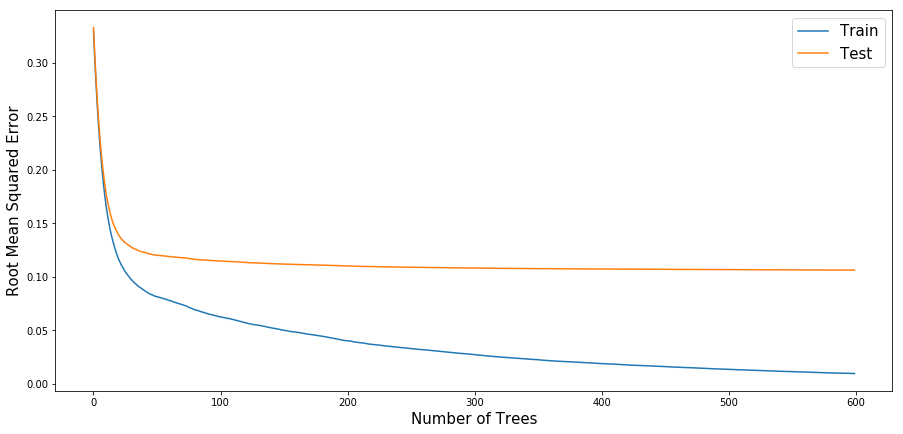

In [5]:
'''
Set default hyperparameter values, then monitor model performance (rmse) as trees are added.
'''

defaults = {'objective': 'reg:linear', 'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.1, 
            'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 
            'reg_alpha': 0.001, 'reg_lambda': 10.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

target = targets[8]

# Fit model to training data
xgb1     = XGBRegressor(**defaults)
eval_set = [(df0_train[predictors], df0_train[target]), 
            (df0_test[predictors], df0_test[target])]
%time xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], eval_set=eval_set, verbose=False)

# Make predictions for test data
df0_test_predictions = xgb1.predict(df0_test[predictors])

# Retrieve performance metrics
results             = xgb1.evals_result()
min_index, min_rmse = min(enumerate(results['validation_1']['rmse']), key=itemgetter(1))
n_trees_best        = min_index + 1
rmse_test           = np.sqrt(mean_squared_error(df0_test[target].values, df0_test_predictions))
n_trees_final       = len(results['validation_1']['rmse'])
print('Algorithm: {0}'.format(xgb1))
print("RMSE on Test Set at Best Iteration:  {0}, Number of Trees: {1}".format(min_rmse, n_trees_best))
print("RMSE on Test Set at Final Iteration: {0}, Number of Trees: {1}".format(rmse_test, n_trees_final))

#  Plot learning curves
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.plot(x_axis, results['validation_0']['rmse'], label='Train')
axis.plot(x_axis, results['validation_1']['rmse'], label='Test')
axis.legend(fontsize=15)
axis.set_xlabel('Number of Trees', fontsize=15)
axis.set_ylabel('Root Mean Squared Error', fontsize=15)
plt.show()

<a id='Cell5'></a>

CPU times: user 2.57 s, sys: 373 ms, total: 2.94 s
Wall time: 28min 8s

Best score: 0.0136067718005, using {'n_estimators': 500, 'max_depth': 8}

0.014064696064 +/- 0.00129872589425, with {'n_estimators': 350, 'max_depth': 6}
0.0139461105942 +/- 0.00127213999354, with {'n_estimators': 400, 'max_depth': 6}
0.0138853345698 +/- 0.00125224981792, with {'n_estimators': 450, 'max_depth': 6}
0.0138098053863 +/- 0.00124080548653, with {'n_estimators': 500, 'max_depth': 6}
0.01369659607 +/- 0.00121311058534, with {'n_estimators': 350, 'max_depth': 8}
0.0136634357112 +/- 0.00120714770406, with {'n_estimators': 400, 'max_depth': 8}
0.0136315628896 +/- 0.0012072537388, with {'n_estimators': 450, 'max_depth': 8}
0.0136067718005 +/- 0.00120636998203, with {'n_estimators': 500, 'max_depth': 8}
0.0143607727659 +/- 0.000952391247848, with {'n_estimators': 350, 'max_depth': 10}
0.0143495289719 +/- 0.000950714135872, with {'n_estimators': 400, 'max_depth': 10}
0.0143416407732 +/- 0.000950063016399, with 

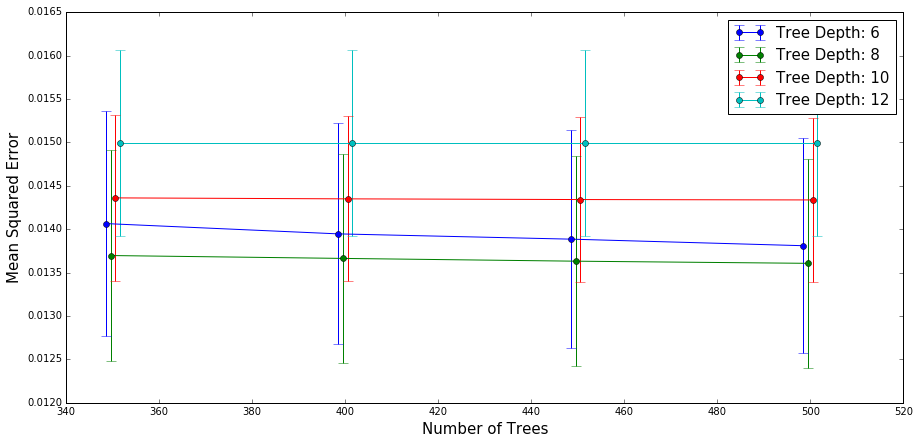

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [7]:
'''
Tune the number and size of trees using cross-validation.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'max_depth': [6, 8, 10, 12]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['max_depth'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset = [-1.5, -0.5, 0.5, 1.5]
for i, value in enumerate(searchGrid['max_depth']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Tree Depth: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell6'></a>

CPU times: user 2 s, sys: 296 ms, total: 2.3 s
Wall time: 22min 42s

Best score: 0.0136067718005, using {'n_estimators': 500, 'learning_rate': 0.1}

0.0752033045266 +/- 0.00182491137016, with {'n_estimators': 350, 'learning_rate': 0.001}
0.0701002778035 +/- 0.00168321857019, with {'n_estimators': 400, 'learning_rate': 0.001}
0.0654574729605 +/- 0.00155232504786, with {'n_estimators': 450, 'learning_rate': 0.001}
0.0612354356737 +/- 0.00144208224008, with {'n_estimators': 500, 'learning_rate': 0.001}
0.0162501170597 +/- 0.00135866120478, with {'n_estimators': 350, 'learning_rate': 0.01}
0.0158106544306 +/- 0.00134520571, with {'n_estimators': 400, 'learning_rate': 0.01}
0.0154950009453 +/- 0.00133985983821, with {'n_estimators': 450, 'learning_rate': 0.01}
0.0152608872045 +/- 0.00132020158172, with {'n_estimators': 500, 'learning_rate': 0.01}
0.01369659607 +/- 0.00121311058534, with {'n_estimators': 350, 'learning_rate': 0.1}
0.0136634357112 +/- 0.00120714770406, with {'n_estimators': 4

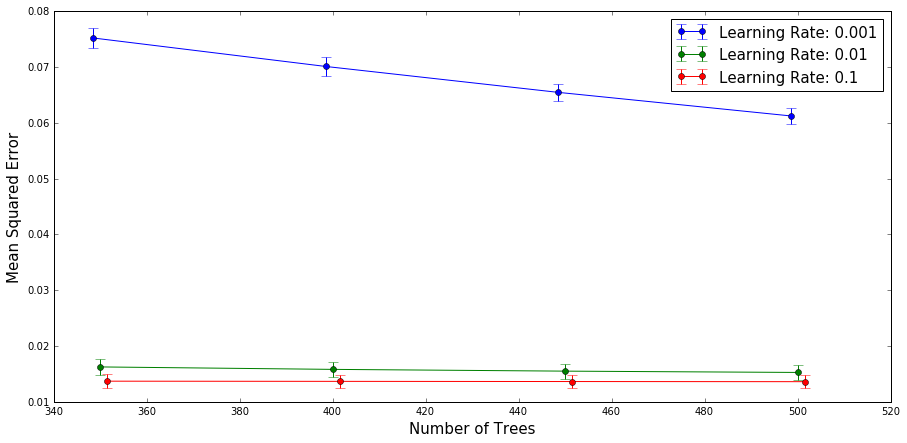

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 1, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [8]:
'''
Tune the learning rate and the number of trees using cross-validation.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'n_estimators': [350, 400, 450, 500], 'learning_rate': [0.001, 0.01, 0.1]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(-mean, stdev, param))
        
# Plot results (flip the score signs so we have mse instead of -mse).
n_xval    = len(searchGrid['n_estimators'])
n_yval    = len(searchGrid['learning_rate'])
scores    = -np.array(means).reshape(n_yval, n_xval)
escores   = np.array(stds).reshape(n_yval, n_xval)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x_offset  = [-1.5, 0.0, 1.5]
for i, value in enumerate(searchGrid['learning_rate']):
    plt.errorbar(x_offset[i]+np.array(searchGrid['n_estimators']), scores[i], 
                 yerr=escores[i], fmt='-o', capsize=5, label='Learning Rate: '+str(value))
plt.legend(fontsize=15)
plt.xlabel('Number of Trees', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell7'></a>

CPU times: user 1.55 s, sys: 250 ms, total: 1.8 s
Wall time: 15min 13s

Best score: 0.0135101283351, using {'subsample': 0.9}

0.0200953143166 +/- 0.00154783911522, with {'subsample': 0.1}
0.0163537088172 +/- 0.00121088373159, with {'subsample': 0.2}
0.0150476603946 +/- 0.00108717153923, with {'subsample': 0.3}
0.0142129125764 +/- 0.00125605605247, with {'subsample': 0.4}
0.0140098332343 +/- 0.00115105668092, with {'subsample': 0.5}
0.0138378389624 +/- 0.00131943988452, with {'subsample': 0.6}
0.0135944770067 +/- 0.00117094505373, with {'subsample': 0.7}
0.0136191967964 +/- 0.00128520206145, with {'subsample': 0.8}
0.0135101283351 +/- 0.00121481035028, with {'subsample': 0.9}
0.0136067718005 +/- 0.00120636998203, with {'subsample': 1.0}


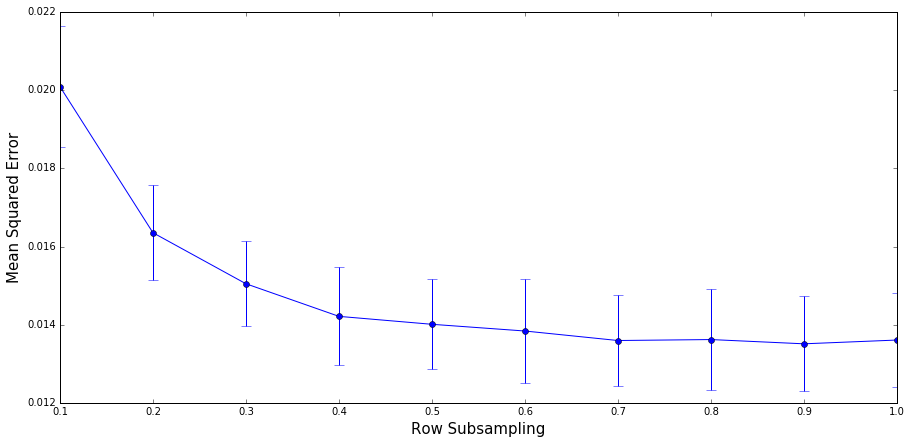

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 1.0, 'silent': True, 'nthread': -1, 'subsample': 0.9, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [9]:
'''
Tune the row subsampling.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['subsample'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Row Subsampling', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell8'></a>

CPU times: user 1.04 s, sys: 180 ms, total: 1.22 s
Wall time: 9min

Best score: 0.0134497883786, using {'colsample_bytree': 0.7}

0.0136303796819 +/- 0.00114253557086, with {'colsample_bytree': 0.4}
0.0138385345148 +/- 0.00116736973716, with {'colsample_bytree': 0.5}
0.0136443850133 +/- 0.00100535197812, with {'colsample_bytree': 0.6}
0.0134497883786 +/- 0.00118724059938, with {'colsample_bytree': 0.7}
0.0134738635184 +/- 0.00118281563193, with {'colsample_bytree': 0.8}
0.0136355619199 +/- 0.00119121576658, with {'colsample_bytree': 0.9}
0.0135101283351 +/- 0.00121481035028, with {'colsample_bytree': 1.0}


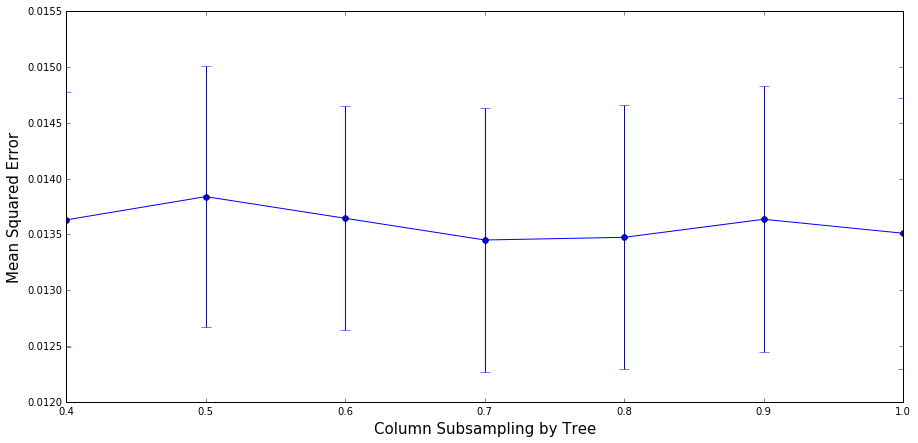

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 1, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 0.7, 'silent': True, 'nthread': -1, 'subsample': 0.9, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [10]:
'''
Tune the column subsampling by tree.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bytree'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Tree', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell9'></a>

CPU times: user 1.02 s, sys: 159 ms, total: 1.18 s
Wall time: 6min 50s

Best score: 0.0134028048463, using {'colsample_bylevel': 0.8}

0.0137611815731 +/- 0.0012204248133, with {'colsample_bylevel': 0.4}
0.0137477100417 +/- 0.00118015043552, with {'colsample_bylevel': 0.5}
0.0136385955782 +/- 0.00133688871375, with {'colsample_bylevel': 0.6}
0.013535354159 +/- 0.00117399174656, with {'colsample_bylevel': 0.7}
0.0134028048463 +/- 0.00115148434277, with {'colsample_bylevel': 0.8}
0.0135944080805 +/- 0.00121562248729, with {'colsample_bylevel': 0.9}
0.0134497883786 +/- 0.00118724059938, with {'colsample_bylevel': 1.0}


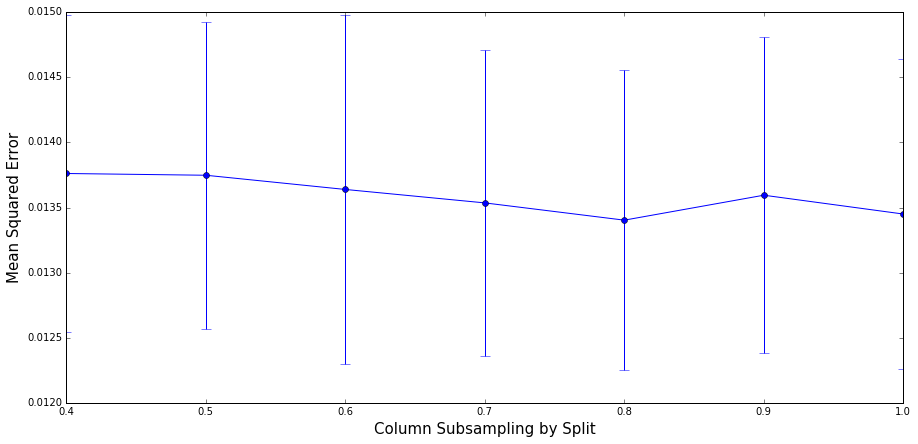

Updated settings: {'reg_alpha': 0, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 0.7, 'silent': True, 'nthread': -1, 'subsample': 0.9, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [11]:
'''
Tune the column subsampling by split.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plt.errorbar(searchGrid['colsample_bylevel'], means, yerr=stds, fmt='-o', capsize=5)
plt.xlabel('Column Subsampling by Split', fontsize=15)
plt.ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell10'></a>

CPU times: user 1.17 s, sys: 171 ms, total: 1.35 s
Wall time: 8min 29s

Best score: 0.0132531670045, using {'reg_alpha': 0.1}

0.0134583557093 +/- 0.00115680197793, with {'reg_alpha': 1e-05}
0.0135148067283 +/- 0.00121094286401, with {'reg_alpha': 0.0001}
0.0135512170505 +/- 0.00122862648937, with {'reg_alpha': 0.001}
0.0134616020389 +/- 0.00118652834414, with {'reg_alpha': 0.01}
0.0132531670045 +/- 0.00129048722483, with {'reg_alpha': 0.1}
0.0134881252631 +/- 0.0010447777327, with {'reg_alpha': 1.0}
0.0190109464191 +/- 0.00120713464599, with {'reg_alpha': 10.0}
0.0321435755633 +/- 0.00106035293669, with {'reg_alpha': 100.0}


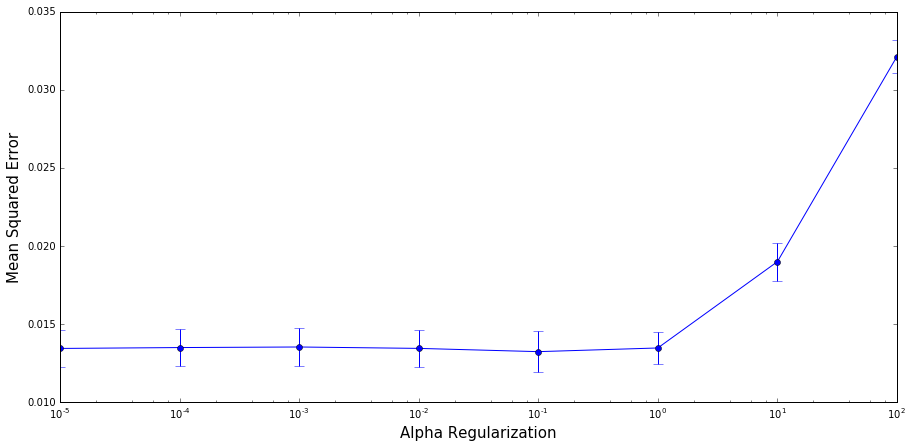

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 0.7, 'silent': True, 'nthread': -1, 'subsample': 0.9, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 8}


In [12]:
'''
Tune the alpha regularization parameter.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'reg_alpha': [1.0E-05, 1.0E-04, 1.0E-03, 1.0E-02, 0.1, 1.0, 10.0, 100.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_alpha'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Alpha Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

<a id='Cell11'></a>

CPU times: user 861 ms, sys: 169 ms, total: 1.03 s
Wall time: 7min 4s

Best score: 0.0131543649576, using {'reg_lambda': 10.0}

0.0133647042558 +/- 0.00119408324798, with {'reg_lambda': 0.01}
0.0134896238004 +/- 0.00107323026472, with {'reg_lambda': 0.1}
0.0132531670045 +/- 0.00129048722483, with {'reg_lambda': 1.0}
0.0131543649576 +/- 0.00113534369182, with {'reg_lambda': 10.0}
0.0136038491369 +/- 0.00116426495508, with {'reg_lambda': 100.0}


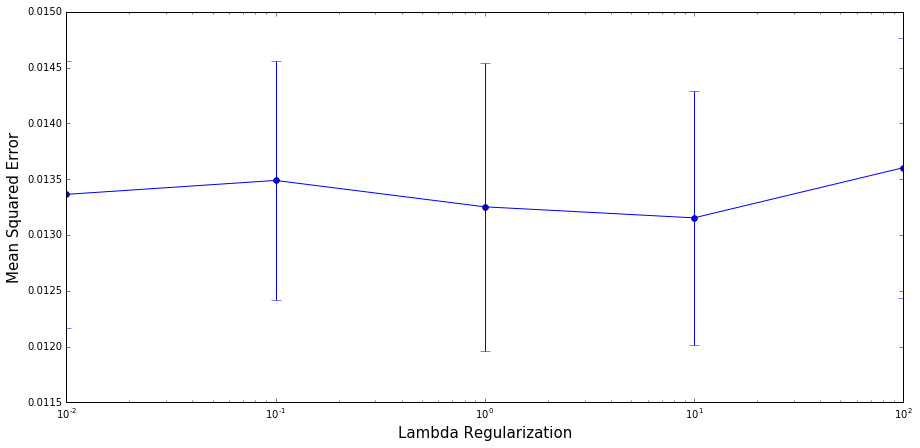

Updated settings: {'reg_alpha': 0.1, 'colsample_bylevel': 0.8, 'learning_rate': 0.1, 'n_estimators': 500, 'seed': 0, 'colsample_bytree': 0.7, 'silent': True, 'nthread': -1, 'subsample': 0.9, 'reg_lambda': 10.0, 'objective': 'reg:linear', 'max_depth': 8}


In [13]:
'''
Tune the lambda regularization parameter.
'''

# Grid search
xgb1 = XGBRegressor(**defaults)
searchGrid = {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}
gSearch = GridSearchCV(xgb1, searchGrid, scoring='neg_mean_squared_error', n_jobs=-1, 
                       iid=True, cv=5, refit=False)
%time gSearch.fit(df0_train[predictors], df0_train[target])

# Summarize results
print('\nBest score: {0}, using {1}\n'.format(-gSearch.best_score_, gSearch.best_params_))
means  = -gSearch.cv_results_['mean_test_score']
stds   = gSearch.cv_results_['std_test_score']
params = gSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} +/- {1}, with {2}'.format(mean, stdev, param))
        
# Plot results
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axis.errorbar(searchGrid['reg_lambda'], means, yerr=stds, fmt='-o', capsize=5)
axis.set_xlabel('Lambda Regularization', fontsize=15)
axis.set_xscale('log')
axis.set_ylabel('Mean Squared Error', fontsize=15)
plt.show()

# Update defaults
defaults.update(gSearch.best_params_)
print('Updated settings: {0}'.format(defaults))

## Fit model to training subset of training sample and check properties on test subset.

<a id='Cell12'></a>

In [ ]:
'''
Create separate models for each of the ten turbines, using cross-validation.
'''

defaults = {'objective': 'reg:linear', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1, 
            'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 
            'reg_alpha': 0.1, 'reg_lambda': 10.0, 
            'seed': 0, 'nthread': -1, 'silent': True}

searchGrids = [{'learning_rate': [0.1]}, 
               {'max_depth': [8]},
               {'subsample': [0.9]},
               {'colsample_bytree': [0.7]},
               {'colsample_bylevel': [0.8]},
               {'reg_alpha': [1.0E-02]},
               {'reg_lambda': [10]}]

settings  = [defaults.copy() for _ in range(nturbines)]
xgbr_train_all = []
for target, setting in zip(targets, settings):
    print('\nFitting turbine {0}...'.format(target[10:]))
    for grid in searchGrids:
        gSearch = GridSearchCV(estimator=XGBRegressor(**setting), param_grid=grid, 
                               scoring='neg_mean_squared_error', n_jobs=-1, iid=True, cv=5, refit=False)
        gSearch.fit(df0_train[predictors], df0_train[target])
        setting.update(gSearch.best_params_)
        print('   Updated parameters: {0}, best score: {1}'.format(gSearch.best_params_, gSearch.best_score_))
    xgb1 = XGBRegressor(**setting)
    xgb1.fit(df0_train[predictors], df0_train[target], eval_metric=["rmse"], verbose=False)
    xgbr_train_all.append(xgb1)
    
fName = 'xgbr_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_train_all, path_to_file)  
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))

In [ ]:
'''
Retrieve from disk the regressor model that was trained on the training subsample only. 
'''

xgbr_found = True

try:
    xgbr_train_all
except:
#    fName = 'xgbr_train_2017_03_29_02_35_39' # rm=3, dups removed, (U,V,time) replaced by (H)
#    fName = 'xgbr_train_2017_03_28_04_50_26' # rm=3, dups removed
#    fName = 'xgbr_train_2017_10_23_03_15_30' # rm=3, dups removed, single obs retained
#    fName = 'xgbr_train_2017_03_10_21_31_44' # rm=3
#    fName = 'xgbr_train_2017_03_11_06_51_08' # rm=4
#    fName = 'xgbr_train_2017_03_12_04_27_43' # rm=2
#    fName = 'xgbr_train_2017_03_10_03_54_47'
    fName = 'xgbr_train_2017_03_08_10_53_03'
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_train_all = joblib.load(path_to_file)
    except:
        print('Error loading regressor model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regressor model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Regressor model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_train_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

<a id='Cell14'></a>

In [10]:
'''
Test the fitted models on the testing subset.
'''

Nturbines       = len(xgbr_train_all)
MSE_Train_Total = 0.0
MSE_Test_Total  = 0.0
for ind,xgb in enumerate(xgbr_train_all):
    
    target = 'TARGETVAR_'+str(ind+1)
    
    # Predict training set and testing set
    df0_train_predictions = xgb.predict(df0_train[predictors])
    df0_test_predictions  = xgb.predict(df0_test[predictors])
    df0_train_predictions = [min(max(x,0.0),1.0) for x in df0_train_predictions]
    df0_test_predictions  = [min(max(x,0.0),1.0) for x in df0_test_predictions]
    
    # Compute performance measures
    R2_Train  = r2_score(df0_train[target].values, df0_train_predictions)
    R2_Test   = r2_score(df0_test[target].values, df0_test_predictions)
    MSE_Train = mean_squared_error(df0_train[target].values, df0_train_predictions)
    MSE_Test  = mean_squared_error(df0_test[target].values, df0_test_predictions)

    # Compute confusion matrix for classifying zero turbine output
    cm = confusion_matrix([1 if v==0.0 else 0 for v in df0_test[target]], 
                          [1 if v==0.0 else 0 for v in df0_test_predictions])
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    
    # Print model report
    print('\nModel Report for Turbine {0}'.format(ind+1))
    print('On training set: R^2 =  {0}'.format(R2_Train))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Train)))
    print('On testing set:  R^2 =  {0}'.format(R2_Test))
    print('                 RMSE = {0}'.format(np.sqrt(MSE_Test)))
    print('                 Confusion Matrix: tp = {0}, fn = {1}, fp = {2}, tn = {3}'.format(tp, fn, fp, tn))
    MSE_Train_Total += MSE_Train
    MSE_Test_Total  += MSE_Test
print('\nTotal RMSE on training set: {0}'.format(np.sqrt(MSE_Train_Total/Nturbines)))
print('Total RMSE on testing set:  {0}'.format(np.sqrt(MSE_Test_Total/Nturbines)))


Model Report for Turbine 1
On training set: R^2 =  0.9982518036645952
                 RMSE = 0.011565665166548578
On testing set:  R^2 =  0.8922668275974105
                 RMSE = 0.09247998432029274
                 Confusion Matrix: tp = 73, fn = 313, fp = 16, tn = 3469

Total RMSE on training set: 0.011565665166548578
Total RMSE on testing set:  0.09247998432029274


<a id='Cell14b'></a>

In [ ]:
'''
Make histograms of the response variable in the training and testing subsets of the training data set.
'''

predicted_targets_train = []
actual_targets_train    = []
predicted_targets_test  = []
actual_targets_test     = []
for ind,xgb in enumerate(xgbr_train_all):
    target = 'TARGETVAR_'+str(ind+1)
    df0_train_predictions = xgb.predict(df0_train[predictors])
    df0_train_predictions = [min(max(x,0.0),1.0) for x in df0_train_predictions]
    predicted_targets_train.extend(df0_train_predictions)
    actual_targets_train.extend(df0_train[target].values)
    df0_test_predictions  = xgb.predict(df0_test[predictors])
    df0_test_predictions  = [min(max(x,0.0),1.0) for x in df0_test_predictions]
    predicted_targets_test.extend(df0_test_predictions)
    actual_targets_test.extend(df0_test[target].values)

fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(10,10) )
axis[0].hist(predicted_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='predicted')
axis[0].hist(actual_targets_train, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='actual')
axis[0].set_xlabel("Turbine output", fontsize=15)
axis[0].legend(prop={'size': 15},loc="upper right")
axis[0].text(0.08, 0.85, "Training Subset", fontsize=15, transform=axis[0].transAxes)

axis[1].hist(predicted_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='blue', alpha=0.3, edgecolor='k', label='predicted')
axis[1].hist(actual_targets_test, bins=100, range=[0.,1.], normed=False, histtype='bar', align='mid', 
             orientation='vertical', log=False, color='green', alpha=0.3, edgecolor='k', label='actual')
axis[1].set_xlabel("Turbine output", fontsize=15)
axis[1].legend(prop={'size': 15},loc="upper right")
axis[1].text(0.08, 0.85, "Testing Subset", fontsize=15, transform=axis[1].transAxes)

plt.show()
fig.savefig('wind_turbine_output_train_test_xgb.png', dpi=200, bbox_inches='tight')

<a id='Cell14c'></a>

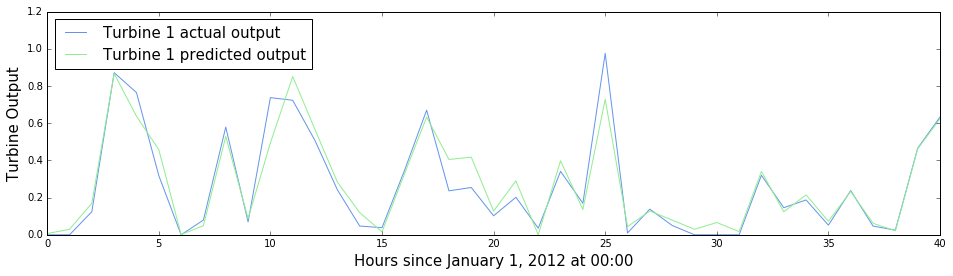

In [24]:
'''
Plot predicted and actual turbine power as a function of time.
'''
turbine = 1
npts    = 41

npts_pt = len(predicted_targets_test)/nturbines
npts_a  = min(npts, npts_pt)
ifirst  = npts_pt*(turbine-1)
ilast   = ifirst + npts_a
xval    = range(0, npts_a)
yval    = actual_targets_test[ifirst:ilast]
zval    = predicted_targets_test[ifirst:ilast]

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(16,4))

axis.plot(xval, yval, color="cornflowerblue", alpha=1.0, label="Turbine "+str(turbine)+" actual output")
axis.plot(xval, zval, color="lightgreen", alpha=1.0, label="Turbine "+str(turbine)+" predicted output")
axis.set_xlim([0., npts_a-1])
axis.set_ylim([0., 1.2])
axis.set_xlabel("Hours since January 1, 2012 at 00:00", fontsize=15)
axis.set_ylabel("Turbine Output", fontsize=15)
axis.legend(prop={'size': 15},loc="upper left")

plt.show()
fig.savefig('pred_actual_vs_time_1.png', dpi=200, bbox_inches='tight')

<a id='Cell15'></a>

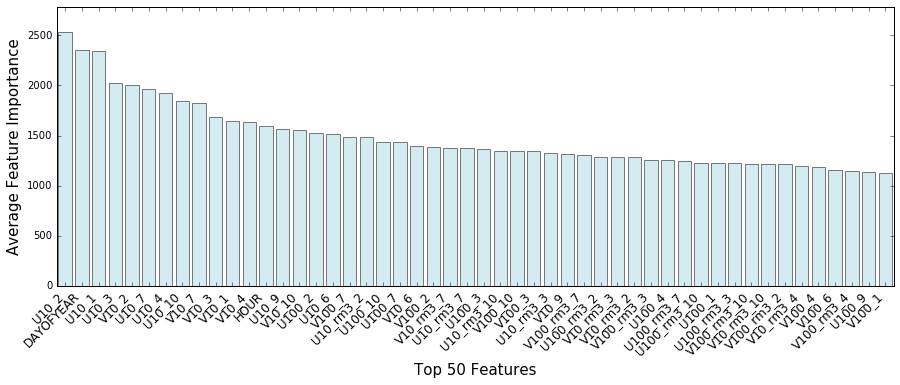

In [17]:
'''
Plot feature importances averaged over all turbines.
'''

all_feat_imp = []
for xgb in xgbr_train_all:
    all_feat_imp.append(xgb.booster().get_score(importance_type='weight'))
all_feat_imp_df = pd.DataFrame(all_feat_imp)
feat_imp        = all_feat_imp_df.mean().sort_values(ascending=False)
n_features      = min(50,len(feat_imp))
bins            = np.arange(n_features)
x_labels        = feat_imp.index.values[:n_features]
y_values        = feat_imp.values[:n_features]
maxHeight       = 1.10*max(y_values)

fig, axes  = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.bar(bins, y_values, align="center", color="lightblue", edgecolor='k', alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=12)
axes.set_xlim([-0.5,bins.size-0.5])
if len(feat_imp) <= 50:
    axes.set_xlabel('Features'.format(n_features), fontsize=15)
else:
    axes.set_xlabel('Top {0} Features'.format(n_features), fontsize=15)
axes.set_ylim([0.0, maxHeight])
axes.set_ylabel('Average Feature Importance', fontsize=15)
plt.show()
fig.savefig('XGBoost35_FeatureImportances.png', dpi=200, bbox_inches='tight')

## Refit model to entire training data set and create solution file.

<a id='Cell16'></a>

In [18]:
'''
Refit model with final settings to entire training data set and save fitted model to disk.
'''

xgbr_all = []
for target, setting in zip(targets, settings):
    xgb2 = XGBRegressor(**setting)
    %time xgb2.fit(df0[predictors], df0[target], eval_metric=["rmse"], verbose=False)
    xgbr_all.append(xgb2)
    
fName = 'xgbr_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgbr_all, path_to_file)
print('\nExtreme gradient boosting regression model saved to {0}'.format(path_to_file))

CPU times: user 1min 17s, sys: 412 ms, total: 1min 17s
Wall time: 1min 18s
CPU times: user 47.8 s, sys: 295 ms, total: 48.1 s
Wall time: 49.1 s
CPU times: user 44.5 s, sys: 153 ms, total: 44.7 s
Wall time: 44.9 s
CPU times: user 45.1 s, sys: 296 ms, total: 45.4 s
Wall time: 46.4 s
CPU times: user 56.9 s, sys: 424 ms, total: 57.3 s
Wall time: 58.6 s
CPU times: user 32.1 s, sys: 146 ms, total: 32.2 s
Wall time: 32.6 s
CPU times: user 52.7 s, sys: 217 ms, total: 53 s
Wall time: 53.3 s
CPU times: user 1min 6s, sys: 288 ms, total: 1min 6s
Wall time: 1min 6s
CPU times: user 1min 6s, sys: 374 ms, total: 1min 7s
Wall time: 1min 8s
CPU times: user 47.6 s, sys: 226 ms, total: 47.8 s
Wall time: 48.3 s

Extreme gradient boosting regression model saved to fitted_models/xgbr_2017_10_23_04_01_19.model


<a id='Cell17'></a>

In [12]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

xgbr_found = True

try:
    xgbr_all
except:
#    fName = 'xgb_2017_03_05_17_57_26' # No rolling average
#    fName = 'xgbr_2017_03_12_10_24_46' # rm=2
#    fName = 'xgbr_2017_03_10_22_09_58' # rm=3
#    fName = 'xgbr_2017_03_11_07_25_35' # rm=4
#    fName = 'xgbr_2017_03_28_07_24_58' # rm=3, dups removed
    fName = 'xgbr_2017_10_23_04_01_19' # rm=3, dups removed, single obs retained
#    fName = 'xgbr_2017_03_29_05_13_48' # rm=3, dups removed, (U,V,time) replaced by (H)
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        xgbr_all = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        xgbr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if xgbr_found:
    for ind, xgbr in enumerate(xgbr_all):
        print('Turbine {0}:\nRegressor: {1}\n'.format(ind+1, xgbr))

Regression model successfully loaded from fitted_models/xgbr_2017_03_28_07_24_58.model

Turbine 1:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=1.0,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 2:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0.1, reg_lambda=10.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Turbine 3:
Regressor: XGBRegressor(base_score=0.5, colsample_bylevel=0.6, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, mi

<a id='Cell18'></a>

In [19]:
'''
Prepare the test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Load the testing data
#TestingDataFile = "data/Test_pp_2017_03_02_15_47_36.pkl" # Without rolling average
#TestingDataFile = "data/Test_pp_2017_03_12_10_32_09.pkl" # rm=2
#TestingDataFile = "data/Test_pp_2017_03_10_15_38_00.pkl" # rm=3
#TestingDataFile = "data/Test_pp_2017_03_11_02_07_04.pkl" # rm=4
#TestingDataFile = "data/Test_pp_2017_03_28_09_02_52.pkl" # rm=3, dups removed
TestingDataFile = "data/Test_pp_2017_10_22_17_24_03.pkl" # rm=3, dups removed, single obs retained
df1             = pd.read_pickle(TestingDataFile)

# Rename dataframe columns and make lists with the new predictor labels
predictors  = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]!='ID']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
ids         = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]=='ID']
df1.columns = ids+predictors

# Count how many sets of observations we have in August and September 2013
nTotal      = len(df1)
nAugSep2013 = len([DoY for DoY in df1['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            {0}'.format(nTotal))
print('Number of observation times in August and September 2013: {0}'.format(nAugSep2013))

# If needed, transform predictor variables to be the same as in the gamlss analysis
if gamlss:
    for i in range(0,len(wind_measurements)):
        df1[H10label[i]]  = np.sqrt(df1[U10label[i]]**2 + df1[V10label[i]]**2)
        df1[H100label[i]] = np.sqrt(df1[U100label[i]]**2 + df1[V100label[i]]**2)
    df1.drop(U10label,  1, inplace=True)
    df1.drop(U100label, 1, inplace=True)
    df1.drop(V10label,  1, inplace=True)
    df1.drop(V100label, 1, inplace=True)
    df1.drop(["YEAR", "DAYOFYEAR", "HOUR"], 1, inplace=True)
    predictors = [item for item in df1.columns.values if item[:2]!='ID']

print('\nPredictor variables: {0}'.format(predictors))

# Compute predictions
df1_ids         = []
df1_predictions = []
for ind,xgb in enumerate(xgbr_all):
    obs_id = 'ID_'+str(ind+1)
    df1_ids.extend(df1[obs_id].tolist())
    df1_predictions.extend([min(max(x,0.0),1.0) for x in xgb.predict(df1[predictors])])

# Generate output csv file
fName_out = 'data/xgbr_' + strftime("%Y_%m_%d_%H_%M_%S") + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID","TARGETVAR"])
    for idval,yval in zip(df1_ids, df1_predictions):
        writer.writerow([idval,yval])
print('\nOutput written to {0}'.format(fName_out))


Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

Predictor variables: ['U10_1', 'U10_2', 'U10_3', 'U10_4', 'U10_6', 'U10_7', 'U10_9', 'U10_10', 'V10_1', 'V10_2', 'V10_3', 'V10_4', 'V10_6', 'V10_7', 'V10_9', 'V10_10', 'U100_1', 'U100_2', 'U100_3', 'U100_4', 'U100_6', 'U100_7', 'U100_9', 'U100_10', 'V100_1', 'V100_2', 'V100_3', 'V100_4', 'V100_6', 'V100_7', 'V100_9', 'V100_10', 'U10_rm3_1', 'U100_rm3_1', 'V10_rm3_1', 'V100_rm3_1', 'U10_rm3_2', 'U100_rm3_2', 'V10_rm3_2', 'V100_rm3_2', 'U10_rm3_3', 'U100_rm3_3', 'V10_rm3_3', 'V100_rm3_3', 'U10_rm3_4', 'U100_rm3_4', 'V10_rm3_4', 'V100_rm3_4', 'U10_rm3_6', 'U100_rm3_6', 'V10_rm3_6', 'V100_rm3_6', 'U10_rm3_7', 'U100_rm3_7', 'V10_rm3_7', 'V100_rm3_7', 'U10_rm3_9', 'U100_rm3_9', 'V10_rm3_9', 'V100_rm3_9', 'U10_rm3_10', 'U100_rm3_10', 'V10_rm3_10', 'V100_rm3_10', 'YEAR', 'DAYOFYEAR', 'HOUR']

Output written to data/xgbr_2017_10_23_04_03_11.out.csv


<a id='Cell19'></a>

Shape of solution data frame: (2929, 77)

Shape of final, combined training+solution data frame: (16800, 88)

Number of rmse data points: 100


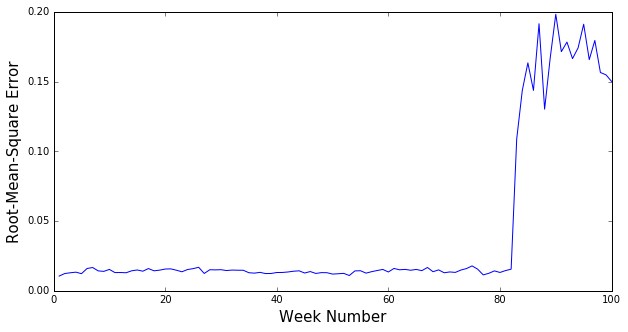

In [20]:
'''
Compute weekly RMSE, save to file and make a plot.
Assume we ran the first two cells of this notebook, so that df0 already contains the training data.
'''

# Select appropriate solution data file.
if rmws==3:
    rm = "_rm3_"
#    SolutionDataFile = "data/Solution_pp_2017_04_23_15_00_18.pkl" # Rolling means over 3 measurements, dups removed
    SolutionDataFile = "data/Solution_pp_2017_10_22_17_25_26.pkl" # rm = 3, dups removed, single obs retained
else:
    print("Solution file with rolling mean over {0} measurement(s) not found.".format(rmws))
    
# Load solution data
df2 = pd.read_pickle(SolutionDataFile)
print('Shape of solution data frame: {0}'.format(df2.shape))

# Rename solution data frame columns to match training data frame.
df2.columns = targets+predictors

# Concatenate the training and solution data frames.
df3 = pd.concat([df0, df2])

# Create timestamp column and use it as index
def ydh_to_dt(row):
    year      = int(row['YEAR'])
    dayofyear = int(row['DAYOFYEAR'])
    hour      = int(row['HOUR'])
    return datetime.datetime(year, 1, 1, hour) + datetime.timedelta(dayofyear - 1)

df3['TIMESTAMP'] = df3.apply(ydh_to_dt, axis=1)
df3.set_index('TIMESTAMP', drop=True, append=False, inplace=True, verify_integrity=True)

# Make predictions
for ind,xgb in enumerate(xgbr_all):
    predicted_target = "PREDICT_"+str(ind+1)
    df3[predicted_target] = [min(max(x,0.0),1.0) for x in xgb.predict(df3[predictors])]

# Compute Mean Squared Error on the ten target variables in each row.
df3['MSE'] = sum([(df3['TARGETVAR_'+str(ind)]-df3['PREDICT_'+str(ind)])**2 for ind in range(1,11)])/10.0

print('\nShape of final, combined training+solution data frame: {0}'.format(df3.shape))

# Compute weekly rmse.
datetime0 = df3.index[0]
rmse      = np.sqrt(df3.groupby((df3.index-datetime0).days/7).MSE.mean())
npts      = len(rmse)
print('\nNumber of rmse data points: {0}'.format(npts))

# Save weekly rmse to file
with open('data/xgbr_weekly_rmse.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(rmse)
    
# Make plot
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
axis.plot(range(1,101), rmse )
axis.set_xlabel("Week Number", fontsize=15)
axis.set_ylabel("Root-Mean-Square Error", fontsize=15)
plt.show()
fig.savefig('xgbr_weekly_rmse.png', dpi=200, bbox_inches='tight')